# VQVAE

## 1) VQVAE reconstruction

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as vision
import torchvision.transforms as tfs
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Import models
from model.residualBlock import Residual_block
from model.encoder import Encoder
from model.decoder import Decoder
from model.vector_quantizer import VectorQuantizer
from model.vqvae import VQVAE

#### Defining parameters

In [4]:
# define VQVAE parameters
BATCH_SIZE = 32
EPOCHS = 500 
LR = 1e-3
DEVICE = 'cuda'
NUM_HIDDENS = 128 # hidden blocks for encoder convolution 
RESIDUAL_INTER = 32 # intermediary residual block channels
NUM_EMBEDDINGS = 512 # number of embeddings for codebook
EMBEDDING_DIM = 64 # dimension of each embedding
COMMITMENT_COST = 0.25 # beta term in loss function
TRAIN_DATA_PATH = '/content/vqvae_data/train' # path to training data
TEST_DATA_PATH = '/content/vqvae_data/test' # path to test data
DATA_VARIANCE = 0.0338 # evaluated seperately on training data

#### Data loading

In [5]:
transform = tfs.Compose([
    tfs.ToTensor()
])
train_ds = vision.datasets.ImageFolder(TRAIN_DATA_PATH, transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_ds = vision.datasets.ImageFolder(TEST_DATA_PATH, transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

#### Model initialisation and training

In [26]:
model = VQVAE(NUM_HIDDENS, RESIDUAL_INTER, NUM_EMBEDDINGS, EMBEDDING_DIM, COMMITMENT_COST)
model.to(DEVICE)

# Init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
training_reconstruction_loss = []

def train_function(dataloader, model, optimizer):
  size = len(dataloader.dataset)
  losses = []
  for batch, (X,_) in enumerate(dataloader):
    X = X.to(device=DEVICE)

    optimizer.zero_grad()
    vq_loss, data_recon = model(X)

    recon_error = F.mse_loss(data_recon, X) / DATA_VARIANCE
    loss = recon_error + vq_loss
    loss.backward()
    optimizer.step()
    losses.append(recon_error.item())

  losses = sum(losses)/len(losses)
  return losses
   
for i in range(2):
  print(f"EPOCH = {i+1}  ")
  lo = train_function(train_dl, model, optimizer)
  training_reconstruction_loss.append(lo)
  print(f"Reconstruction loss: {lo}")

EPOCH = 1  
Reconstruction loss: 0.34048359658544425
EPOCH = 2  
Reconstruction loss: 0.10883635312121435


#### Reconstruction Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


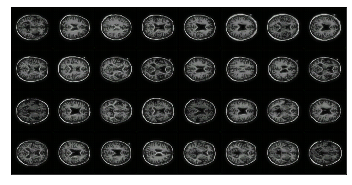

In [27]:
test_real = next(iter(test_dl)) # load some from test dl
test_real = test_real[0]
test_real = test_real.to(DEVICE)
pre_conv = model.conv1(model.encoder(test_real)) # encoder, reshape
_, test_quantized, _, _ = model.vq(pre_conv)
test_reconstructions = model.decoder(test_quantized)

def show(img):
  """
  Plotting func
  """
  npimg = img.numpy()
  fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)

# show reconstructed images
show(make_grid(test_reconstructions.cpu()))

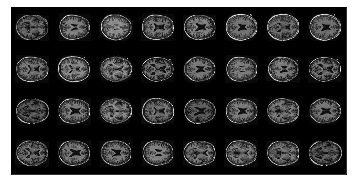

In [28]:
# show real
show(make_grid(test_real.cpu()))